In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import matplotlib.pylab as plt #for visualization
%matplotlib inline    
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/av-genpact-hack-dec2018/meal_info.csv
/kaggle/input/av-genpact-hack-dec2018/fulfilment_center_info.csv
/kaggle/input/av-genpact-hack-dec2018/train.csv
/kaggle/input/av-genpact-hack-dec2018/test.csv


In [3]:
train = pd.read_csv('../input/av-genpact-hack-dec2018/train.csv')
meal = pd.read_csv('../input/av-genpact-hack-dec2018/meal_info.csv')
center = pd.read_csv('../input/av-genpact-hack-dec2018/fulfilment_center_info.csv')

In [4]:
# merge for train data
train = train.merge(center,on='center_id')
train = train.merge(meal,on='meal_id')

In [5]:
data = train[train['center_id']==55]
data = data[data['meal_id'] == 1885]

In [6]:
data

id  week  center_id  meal_id  checkout_price  base_price  \
0    1379560     1         55     1885          136.83      152.29   
1    1018704     2         55     1885          135.83      152.29   
2    1196273     3         55     1885          132.92      133.92   
3    1116527     4         55     1885          135.86      134.86   
4    1343872     5         55     1885          146.50      147.50   
..       ...   ...        ...      ...             ...         ...   
140  1236628   141         55     1885          150.35      150.35   
141  1436751   142         55     1885          148.47      148.47   
142  1161827   143         55     1885          150.35      150.35   
143  1292806   144         55     1885          150.35      152.35   
144  1336751   145         55     1885          156.23      156.23   

     emailer_for_promotion  homepage_featured  num_orders  city_code  \
0                        0                  0         177        647   
1                        0                  0         323        647   
2                        0                  0          96        647   
3                        0                  0         163        647   
4                        0                  0         215        647   
..                     ...                ...         ...        ...   
140                      0                  0         107        647   
141                      0                  0         121        647   
142                      0                  0         176        647   
143                      0                  0         162        647   
144                      0                  0         121        647   

     region_code center_type  op_area   category cuisine  
0             56      TYPE_C      2.0  Beverages    Thai  
1             56      TYPE_C      2.0  Beverages    Thai  
2             56      TYPE_C      2.0  Beverages    Thai  
3             56      TYPE_C      2.0  Beverages    Thai  
4             56      TYPE_C      2.0  Beverages    Thai  
..           ...         ...      ...        ...     ...  
140           56      TYPE_C      2.0  Beverages    Thai  
141           56      TYPE_C      2.0  Beverages    Thai  
142           56      TYPE_C      2.0  Beverages    Thai  
143           56      TYPE_C      2.0  Beverages    Thai  
144           56      TYPE_C      2.0  Beverages    Thai  

[145 rows x 15 columns]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 144
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     145 non-null    int64  
 1   week                   145 non-null    int64  
 2   center_id              145 non-null    int64  
 3   meal_id                145 non-null    int64  
 4   checkout_price         145 non-null    float64
 5   base_price             145 non-null    float64
 6   emailer_for_promotion  145 non-null    int64  
 7   homepage_featured      145 non-null    int64  
 8   num_orders             145 non-null    int64  
 9   city_code              145 non-null    int64  
 10  region_code            145 non-null    int64  
 11  center_type            145 non-null    object 
 12  op_area                145 non-null    float64
 13  category               145 non-null    object 
 14  cuisine                145 non-null    object 
dtypes: flo

In [8]:
corrmat = data.corr()

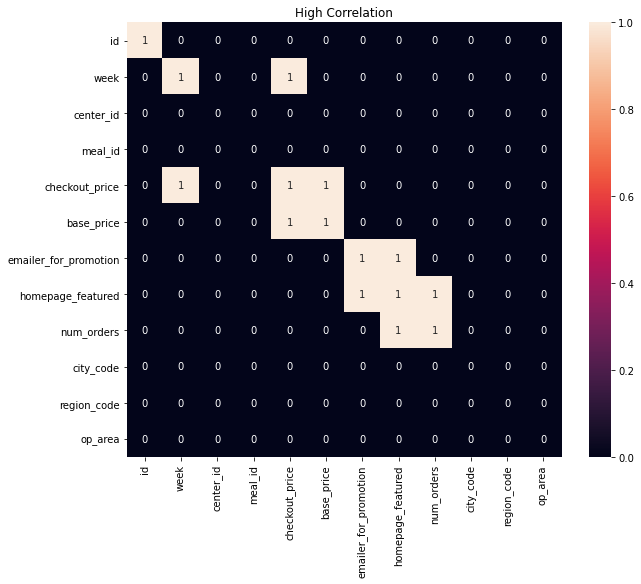

In [9]:

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
num_correlation = data.select_dtypes(exclude='object').corr()
plt.figure(figsize=(10,8))
plt.title('High Correlation')
sns.heatmap(num_correlation > 0.4, annot=True, square=True)



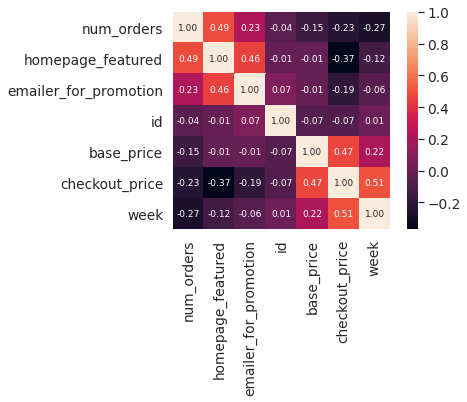

In [10]:
#saleprice correlation matrix
k = 9 #number of variables for heatmap
cols = corrmat.nlargest(k, 'num_orders')['num_orders'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

we will take  homepage_featured,  diff, num order

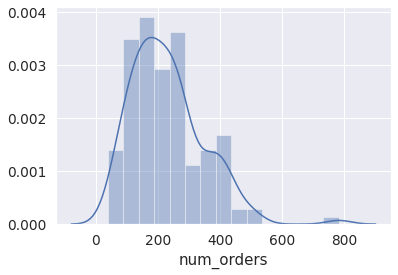

In [11]:
sns.distplot(data['num_orders'])

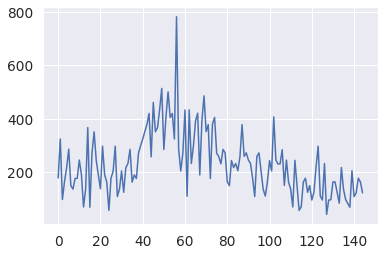

In [12]:
data['num_orders'].plot()

In [13]:
data['num_orders'].skew()

1.0996151799085734

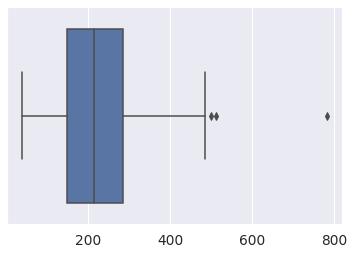

In [14]:
sns.boxplot(['num_orders'], data=data)

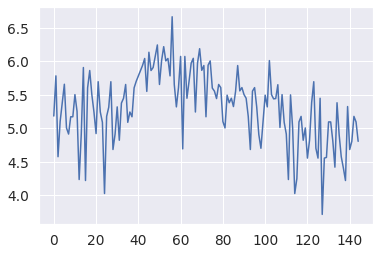

In [15]:
import numpy as np
t = np.log1p(data['num_orders'])
t.plot()

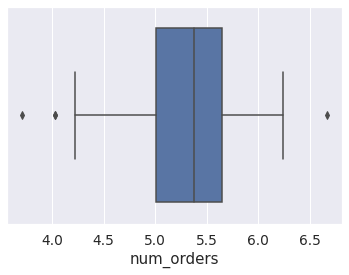

In [16]:
sns.boxplot(t)

In [17]:
data['diff'] = data['base_price']- data['checkout_price']

In [18]:
data

id  week  center_id  meal_id  checkout_price  base_price  \
0    1379560     1         55     1885          136.83      152.29   
1    1018704     2         55     1885          135.83      152.29   
2    1196273     3         55     1885          132.92      133.92   
3    1116527     4         55     1885          135.86      134.86   
4    1343872     5         55     1885          146.50      147.50   
..       ...   ...        ...      ...             ...         ...   
140  1236628   141         55     1885          150.35      150.35   
141  1436751   142         55     1885          148.47      148.47   
142  1161827   143         55     1885          150.35      150.35   
143  1292806   144         55     1885          150.35      152.35   
144  1336751   145         55     1885          156.23      156.23   

     emailer_for_promotion  homepage_featured  num_orders  city_code  \
0                        0                  0         177        647   
1                        0                  0         323        647   
2                        0                  0          96        647   
3                        0                  0         163        647   
4                        0                  0         215        647   
..                     ...                ...         ...        ...   
140                      0                  0         107        647   
141                      0                  0         121        647   
142                      0                  0         176        647   
143                      0                  0         162        647   
144                      0                  0         121        647   

     region_code center_type  op_area   category cuisine   diff  
0             56      TYPE_C      2.0  Beverages    Thai  15.46  
1             56      TYPE_C      2.0  Beverages    Thai  16.46  
2             56      TYPE_C      2.0  Beverages    Thai   1.00  
3             56      TYPE_C      2.0  Beverages    Thai  -1.00  
4             56      TYPE_C      2.0  Beverages    Thai   1.00  
..           ...         ...      ...        ...     ...    ...  
140           56      TYPE_C      2.0  Beverages    Thai   0.00  
141           56      TYPE_C      2.0  Beverages    Thai   0.00  
142           56      TYPE_C      2.0  Beverages    Thai   0.00  
143           56      TYPE_C      2.0  Beverages    Thai   2.00  
144           56      TYPE_C      2.0  Beverages    Thai   0.00  

[145 rows x 16 columns]

In [19]:
# we will take  homepage_featured,  diff, num order
# data.drop(columns=['id','week'])

x = data[['homepage_featured','diff','num_orders']]
x = x.reset_index()

In [20]:
a = x['num_orders'].quantile(0.98)
a

486.80000000000007

In [21]:
# x = x[x['num_orders']<a]


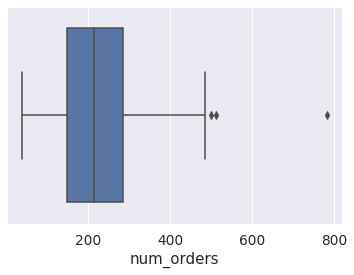

In [22]:
sns.boxplot(x['num_orders'])

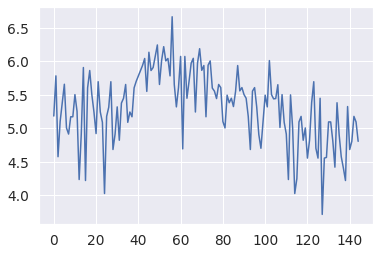

In [23]:
np.log1p(x['num_orders']).plot()

# normalization

In [24]:
# x['num_orders'] = np.log1p(x['num_orders'])
# x

In [25]:
x.drop(columns='index',inplace=True)

In [26]:
# lets partition data

x_train = x.drop(columns='num_orders')
y_train = x['num_orders']


In [27]:
X_train = x_train.iloc[:138,:]
X_test = x_train.iloc[138:,:]
Y_train =  y_train.iloc[:138]
Y_test = y_train.iloc[138:]

In [28]:
print(len(X_test))
print(len(Y_test))

7
7


In [29]:
Y_test

138     67
139    204
140    107
141    121
142    176
143    162
144    121
Name: num_orders, dtype: int64

In [30]:
from xgboost import XGBRegressor
model_2 = XGBRegressor(
 learning_rate =0.3,
 eval_metric='rmse',
    n_estimators=5000,
  
  
 )
#model.fit(X_train, y_train)
model_2.fit(X_train, Y_train, eval_metric='rmse', 
          eval_set=[(X_test, Y_test)], early_stopping_rounds=1000, verbose=100)

[0]	validation_0-rmse:82.80966
Will train until validation_0-rmse hasn't improved in 1000 rounds.
[100]	validation_0-rmse:85.45843
[200]	validation_0-rmse:85.45843
[300]	validation_0-rmse:85.45843
[400]	validation_0-rmse:85.45843
[500]	validation_0-rmse:85.45843
[600]	validation_0-rmse:85.45843
[700]	validation_0-rmse:85.45842
[800]	validation_0-rmse:85.45843
[900]	validation_0-rmse:85.45843
[1000]	validation_0-rmse:85.45843
Stopping. Best iteration:
[2]	validation_0-rmse:43.72977



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
model =XGBRegressor(
 learning_rate =0.001,
    n_estimators=2)
  

In [32]:
model.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.001, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
preds = model.predict(x_train) 

In [34]:
preds

array([0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544,
       0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544,
       0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544,
       0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544,
       0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.6064734, 0.9370544,
       0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544,
       0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544,
       0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544,
       1.3115346, 1.3115346, 1.3115346, 1.3115346, 1.3115346, 1.3115346,
       1.3115346, 1.3115346, 1.3115346, 0.9370544, 0.9370544, 0.9370544,
       0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544,
       0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544,
       0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544, 0.9370544,
       0.9370544, 0.9370544, 0.9370544, 0.9370544, 

In [35]:
# preds = np.exp(preds)


In [36]:
len(preds)

145

In [37]:
# true_value = np.exp(x['num_orders'])
# true_value

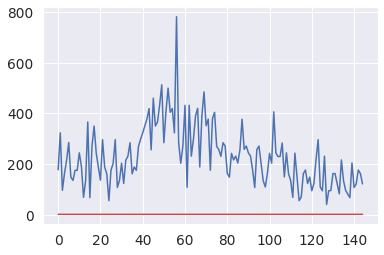

In [38]:
plt.plot(x['num_orders'])
plt.plot(preds, color='r')

# Prohpet model

In [39]:
x

homepage_featured   diff  num_orders
0                    0  15.46         177
1                    0  16.46         323
2                    0   1.00          96
3                    0  -1.00         163
4                    0   1.00         215
..                 ...    ...         ...
140                  0   0.00         107
141                  0   0.00         121
142                  0   0.00         176
143                  0   2.00         162
144                  0   0.00         121

[145 rows x 3 columns]

In [40]:
x['Date'] = pd.date_range('2020-01-01', periods=145, freq='W')
x

homepage_featured   diff  num_orders       Date
0                    0  15.46         177 2020-01-05
1                    0  16.46         323 2020-01-12
2                    0   1.00          96 2020-01-19
3                    0  -1.00         163 2020-01-26
4                    0   1.00         215 2020-02-02
..                 ...    ...         ...        ...
140                  0   0.00         107 2022-09-11
141                  0   0.00         121 2022-09-18
142                  0   0.00         176 2022-09-25
143                  0   2.00         162 2022-10-02
144                  0   0.00         121 2022-10-09

[145 rows x 4 columns]

In [41]:
from fbprophet import Prophet

In [42]:
prophet_model = x[['Date','num_orders']]
prophet_model =prophet_model.rename(columns={'Date':'ds',
                             'num_orders':'y'})
prophet_model

ds    y
0   2020-01-05  177
1   2020-01-12  323
2   2020-01-19   96
3   2020-01-26  163
4   2020-02-02  215
..         ...  ...
140 2022-09-11  107
141 2022-09-18  121
142 2022-09-25  176
143 2022-10-02  162
144 2022-10-09  121

[145 rows x 2 columns]

In [43]:
m = Prophet(changepoint_prior_scale=0.001)
m.fit(prophet_model)


In [44]:
future = m.make_future_dataframe(periods=10)


In [45]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
150 2022-10-15  196.297967   67.836454  319.861513
151 2022-10-16  200.438513   65.337395  328.900663
152 2022-10-17  204.836101   71.742590  340.717623
153 2022-10-18  209.437053   79.007585  339.159239
154 2022-10-19  214.179439   84.674064  345.825297

In [46]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

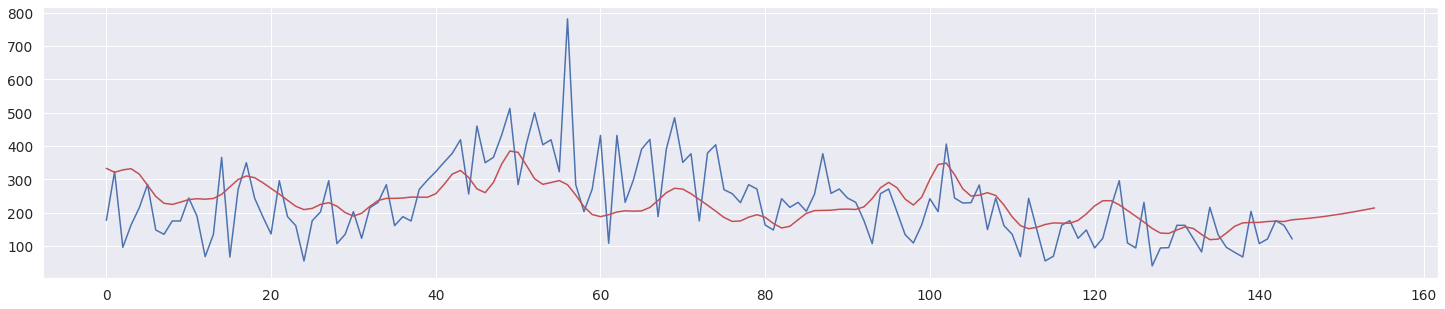

In [47]:
plt.figure(figsize=(25,5))
plt.plot(x['num_orders'])
plt.plot(forecast['yhat'], color='r')

In [48]:
x

homepage_featured   diff  num_orders       Date
0                    0  15.46         177 2020-01-05
1                    0  16.46         323 2020-01-12
2                    0   1.00          96 2020-01-19
3                    0  -1.00         163 2020-01-26
4                    0   1.00         215 2020-02-02
..                 ...    ...         ...        ...
140                  0   0.00         107 2022-09-11
141                  0   0.00         121 2022-09-18
142                  0   0.00         176 2022-09-25
143                  0   2.00         162 2022-10-02
144                  0   0.00         121 2022-10-09

[145 rows x 4 columns]

# Arima

In [49]:
df = x[['Date','num_orders']]
df = df.set_index(['Date'])
df

num_orders
Date                  
2020-01-05         177
2020-01-12         323
2020-01-19          96
2020-01-26         163
2020-02-02         215
...                ...
2022-09-11         107
2022-09-18         121
2022-09-25         176
2022-10-02         162
2022-10-09         121

[145 rows x 1 columns]

In [50]:
rolmean = df.rolling(window=6).mean()
rolstd = df.rolling(window=6).std()

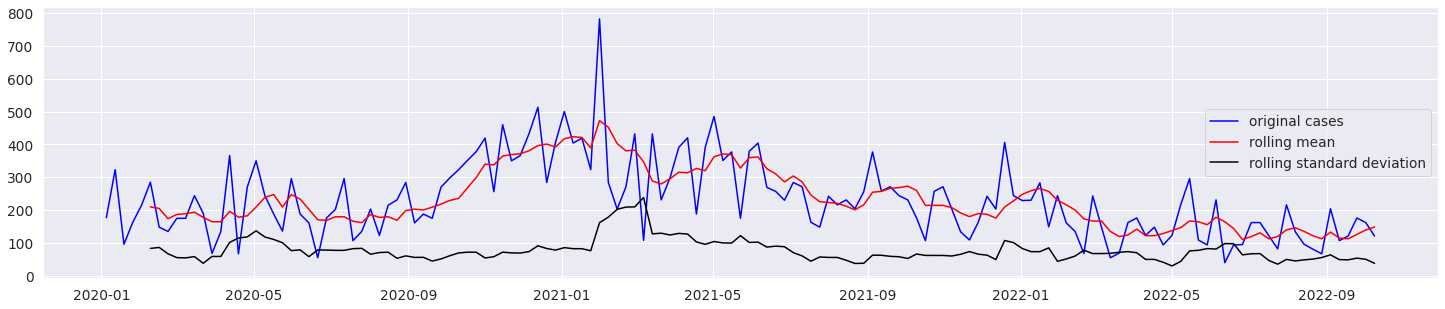

In [51]:
plt.figure(figsize=(25,5))
plt.plot(df, color='blue', label='original cases')
plt.plot(rolmean, color='red', label='rolling mean')
plt.plot(rolstd, color='black', label='rolling standard deviation')
plt.legend(loc='right')
plt.show()

In [52]:
from statsmodels.tsa.stattools import adfuller
def test(data):
    rolmean = data.rolling(window=2).mean()
    rolstd = data.rolling(window=2).std()
    plt.figure(figsize=(25,5))
    plt.plot(data, color='blue', label='original cases')
    plt.plot(rolmean, color='red', label='rolling mean')
    plt.plot(rolstd, color='black', label='rolling standard deviation')
    plt.legend(loc='best')
    plt.show()
    
    dftest = adfuller(data['num_orders'], autolag = 't-stat')
    dfoutput = pd.Series(dftest[0:4], index=['test statitics','p_value','lags used','number of observations'])
    for key,value in dftest[4].items():
        dfoutput['critcal value (%s)'%key] = value
        
    print(dfoutput)

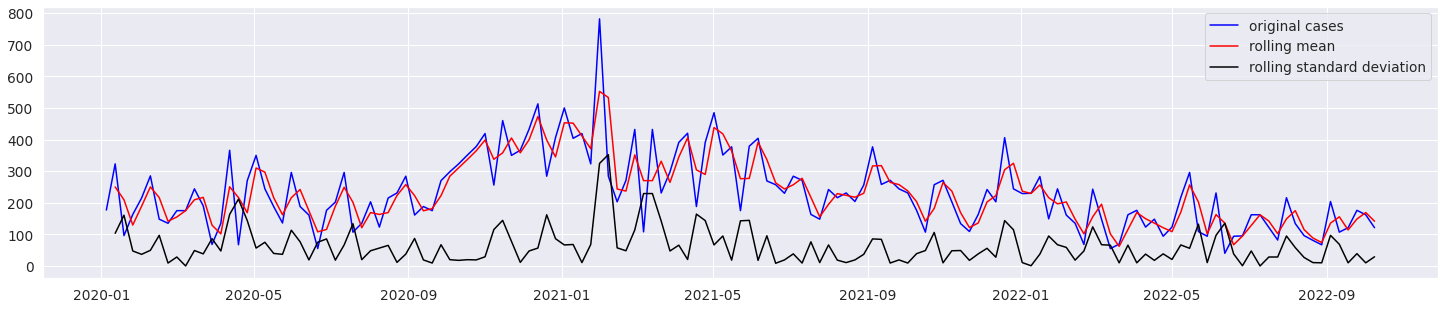

test statitics             -1.207952
p_value                     0.670166
lags used                  12.000000
number of observations    132.000000
critcal value (1%)         -3.480888
critcal value (5%)         -2.883697
critcal value (10%)        -2.578586
dtype: float64


In [53]:
test(df)

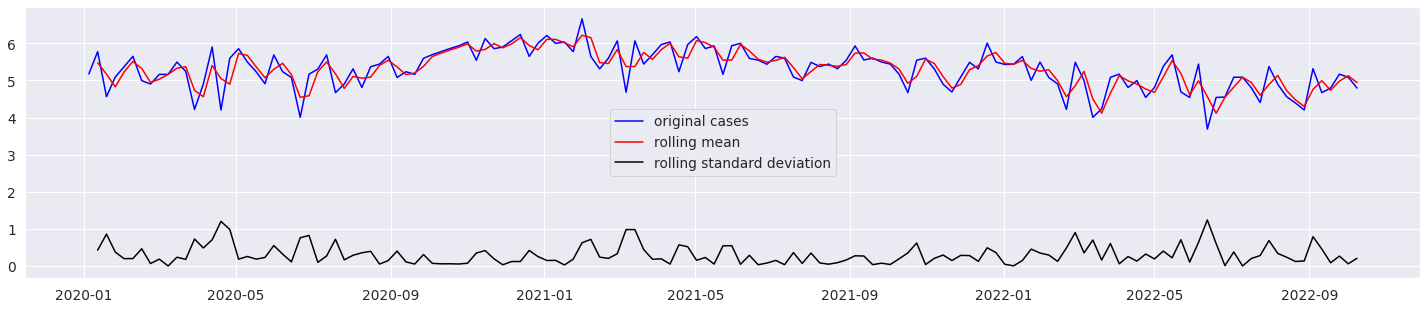

test statitics             -0.943697
p_value                     0.773242
lags used                  12.000000
number of observations    132.000000
critcal value (1%)         -3.480888
critcal value (5%)         -2.883697
critcal value (10%)        -2.578586
dtype: float64


In [54]:
df_log = np.log(df)
test(df_log)

In [55]:
movingaverage = df_log.rolling(window=4).mean()

df_log_minus = df_log - movingaverage
df_log_minus.dropna(inplace=True)
df_log_minus.head(12)

num_orders
Date                  
2020-01-26   -0.059225
2020-02-02    0.169041
2020-02-09    0.482183
2020-02-16   -0.281310
2020-02-23   -0.326129
2020-03-01   -0.015155
2020-03-08    0.106771
2020-03-15    0.314164
2020-03-22   -0.021417
2020-03-29   -0.812614
2020-04-05   -0.061969
2020-04-12    0.834023

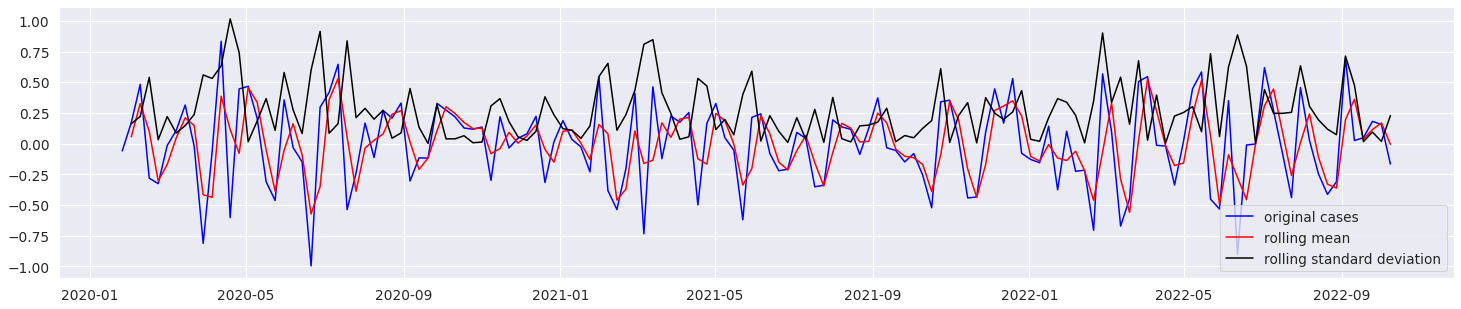

test statitics             -4.487860
p_value                     0.000207
lags used                  14.000000
number of observations    127.000000
critcal value (1%)         -3.482920
critcal value (5%)         -2.884580
critcal value (10%)        -2.579058
dtype: float64


In [56]:
test(df_log_minus)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



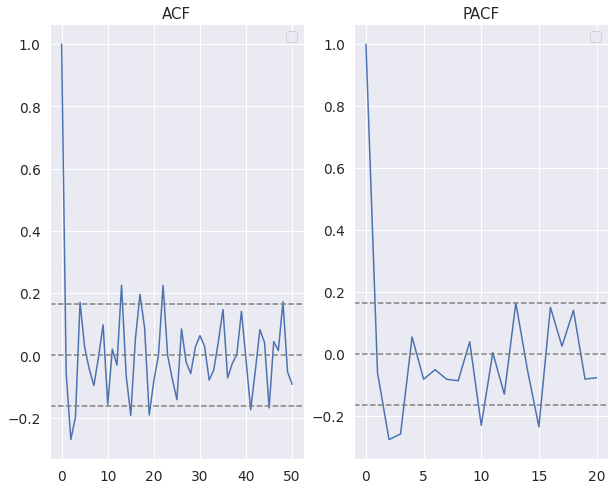

In [57]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_log_minus, nlags=50)
lag_pacf = pacf(df_log_minus, nlags=20, method='ols')

plt.figure(figsize=(10,8))
#plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_minus)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_minus)), linestyle='--', color='gray')
plt.title('ACF')
plt.legend(loc='best')

#plot pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_minus)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_minus)), linestyle='--', color='gray')
plt.title('PACF')
plt.legend(loc='best')

# Y:0 -> X:1 -> q = 1, P=1

From the ACF graph, we see that curve touches y=0.0 line at x=0. Thus, from theory, Q = 0 From the PACF graph, we see that curve touches y=0.0 line at x=1. Thus, from theory, P = 1

**BUILDING MODELS**

Plotting AR model


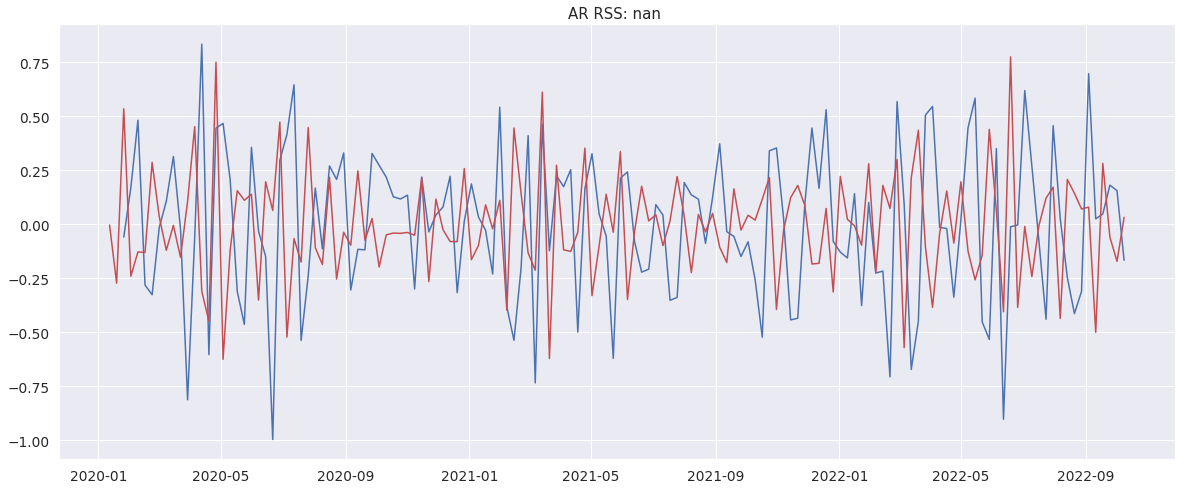

In [58]:
# AR model
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(1,1,0))
result_ar = model.fit(disp=-1)
plt.figure(figsize=(20,8))
plt.plot(df_log_minus)
plt.plot(result_ar.fittedvalues, color='r')
plt.title('AR RSS: %-4f'% sum((result_ar.fittedvalues - df_log_minus['num_orders'])**2))
print('Plotting AR model')

Plotting MA model


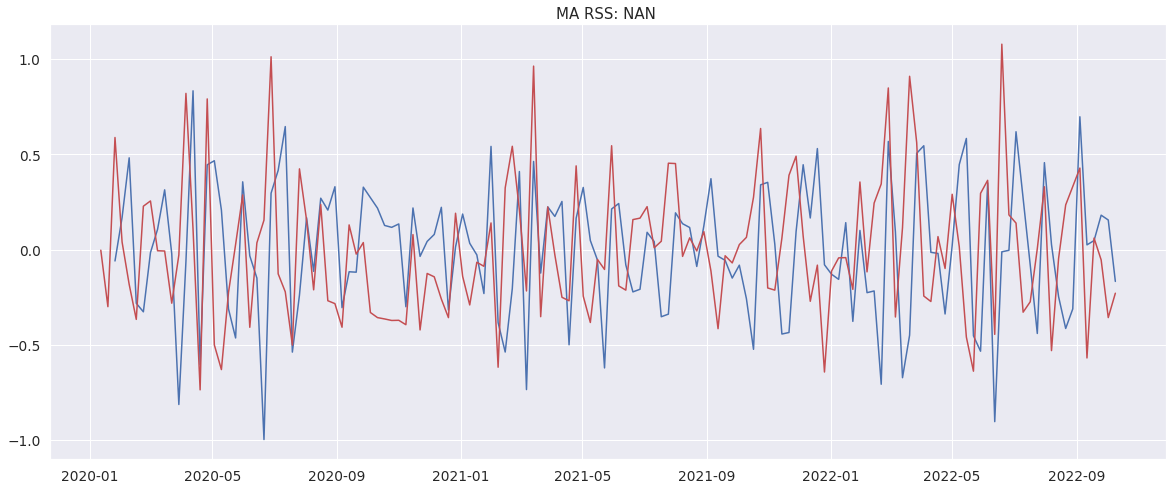

In [59]:
# MA MODEL
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(0,1,1))
result_ma = model.fit(disp=-1)
plt.figure(figsize=(20,8))
plt.plot(df_log_minus)
plt.plot(result_ma.fittedvalues, color='r')
plt.title('MA RSS: %-4F'% sum((result_ma.fittedvalues - df_log_minus['num_orders'])**2))
print('Plotting MA model')

Plotting ARIMA model


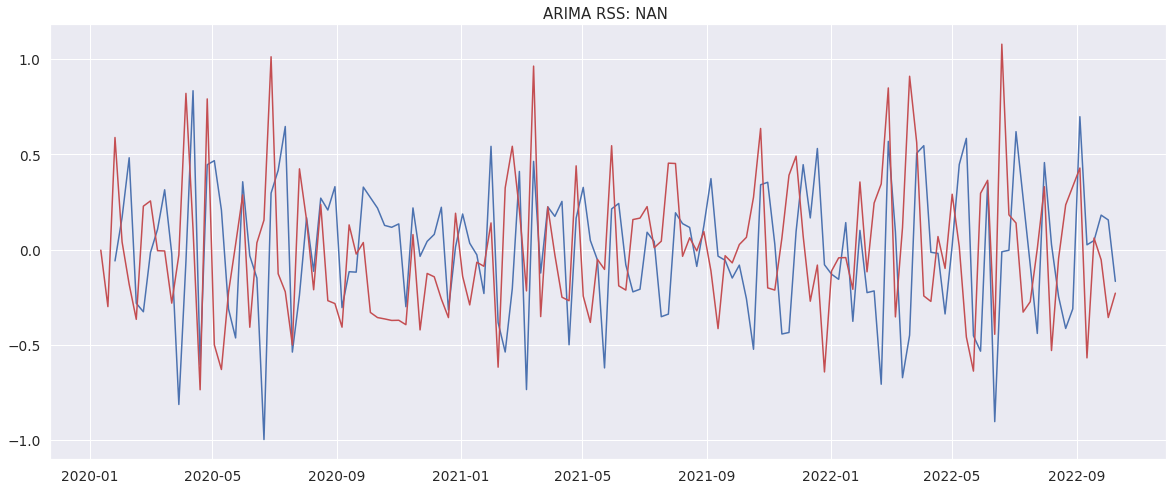

In [60]:
# arima (p,d,q)(1,1,1)
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(1,1,1))
result_arima = model.fit(disp=-1)
plt.figure(figsize=(20,8))
plt.plot(df_log_minus)
plt.plot(result_arima.fittedvalues, color='r')
plt.title('ARIMA RSS: %-4F'% sum((result_arima.fittedvalues - df_log_minus['num_orders'])**2))
print('Plotting ARIMA model')

In [61]:
result_arima.fittedvalues

Date
2020-01-12   -0.002556
2020-01-19   -0.299002
2020-01-26    0.588492
2020-02-02    0.040240
2020-02-09   -0.182118
                ...   
2022-09-11   -0.568024
2022-09-18    0.060954
2022-09-25   -0.053720
2022-10-02   -0.356302
2022-10-09   -0.228479
Length: 144, dtype: float64

In [62]:
pred_arima_diff = pd.Series(result_arima.fittedvalues, copy=True)
pred_arima_diff

Date
2020-01-12   -0.002556
2020-01-19   -0.299002
2020-01-26    0.588492
2020-02-02    0.040240
2020-02-09   -0.182118
                ...   
2022-09-11   -0.568024
2022-09-18    0.060954
2022-09-25   -0.053720
2022-10-02   -0.356302
2022-10-09   -0.228479
Length: 144, dtype: float64

In [63]:
pred_arima_diff_cumsum = pred_arima_diff.cumsum()
pred_arima_diff_cumsum.tail()

Date
2022-09-11    0.278881
2022-09-18    0.339835
2022-09-25    0.286115
2022-10-02   -0.070187
2022-10-09   -0.298666
dtype: float64

In [64]:
prediction = pd.Series(df_log['num_orders'].iloc[0], index=df_log.index)
prediction = prediction.add(pred_arima_diff_cumsum, fill_value=0)
prediction.head()

Date
2020-01-05    5.176150
2020-01-12    5.173594
2020-01-19    4.874592
2020-01-26    5.463084
2020-02-02    5.503323
dtype: float64

In [65]:
prediction = np.exp(prediction)
prediction = prediction.reset_index()
prediction.drop(columns='Date', inplace=True)

# prediction = pd.DataFrame(prediction)

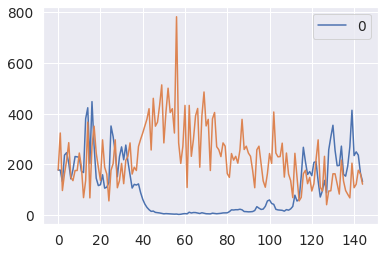

In [66]:
prediction.plot()
x['num_orders'].plot()


In [67]:
forecast['yhat']

0      333.055378
1      321.189185
2      328.479109
3      331.984166
4      315.660532
          ...    
150    196.297967
151    200.438513
152    204.836101
153    209.437053
154    214.179439
Name: yhat, Length: 155, dtype: float64

In [68]:
# a = pd.DataFrame()
b = (forecast['yhat']) 

In [69]:
b[0]

333.05537840084173

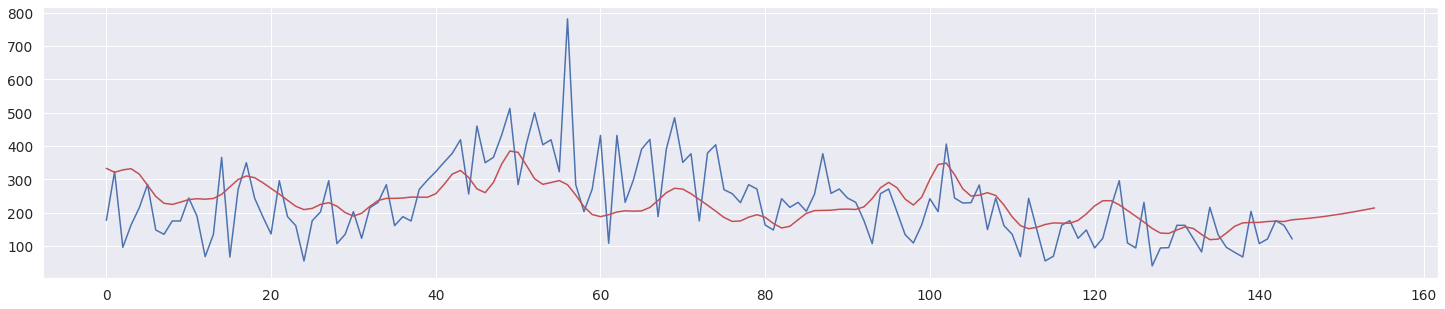

In [70]:
plt.figure(figsize=(25,5))
plt.plot(x['num_orders'])
plt.plot(b, color='r')

<Figure size 720x576 with 0 Axes>

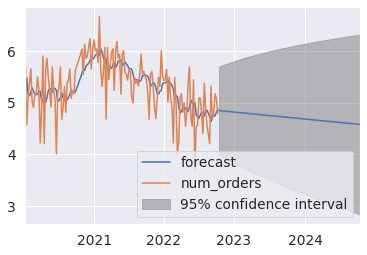

<Figure size 720x576 with 0 Axes>

In [79]:
result_arima.plot_predict(1,250)
plt.figure(figsize=(10,8))

<Figure size 720x576 with 0 Axes>

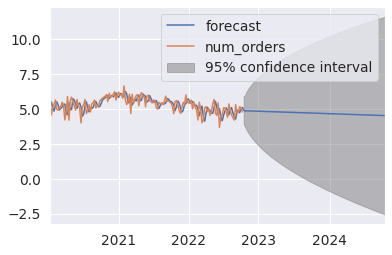

<Figure size 720x576 with 0 Axes>

In [80]:
result_ar.plot_predict(1,250)
plt.figure(figsize=(10,8))

<Figure size 720x576 with 0 Axes>

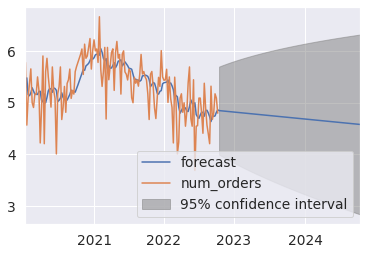

<Figure size 720x576 with 0 Axes>

In [81]:
result_ma.plot_predict(1,250)
plt.figure(figsize=(10,8))